<a href="https://colab.research.google.com/github/Elpida99/Detect-atrial-fibrillation/blob/main/Detect_Atrial_fibrillation_acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/Thesis_Elpida_Makri/Train_model/Detect_Atrial_Fibrillation

/content/drive/My Drive/Thesis_Elpida_Makri/Train_model/Detect_Atrial_Fibrillation


In [ ]:
! ls 
! ls 1_class_data
! ls 1_class_data/dataset_3

1_class_data  models_1_class  my_model.py    my_train.py  __pycache__
logs	      my_datasets.py  my_predict.py  predictions  training.log
af_dataset_ann.csv  dataset_3  X_test.npy  X_train.npy	y_test.npy  y_train.npy
dataset3_annotations.csv  dataset3_tracings.hdf5


In [ ]:
import pandas as pd     
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [ ]:
df_data = pd.read_csv('./1_class_data/dataset_3/dataset3_annotations.csv')
df_af = df_data['AF']
df_af.to_csv('./1_class_data/af_dataset_ann.csv',index=False)

#Load dataset and split

In [ ]:
def load_dataset():

  data = pd.read_csv('./1_class_data/af_dataset_ann.csv')
  y = np.asarray(data)
  print(y.shape)

  with h5py.File('./1_class_data/dataset_3/dataset3_tracings.hdf5', 'r') as hdf:
    x = np.asarray(hdf['tracings']) 
  hdf.close()

  print(x.shape)

  X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.6, shuffle=False)

  return X_train, X_test, y_train, y_test


In [ ]:
X_train, X_test, y_train, y_test = load_dataset()

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

(5170, 1)
(5170, 4096, 12)
X_train:  (3102, 4096, 12)
y_train:  (3102, 1)
X_test:  (2068, 4096, 12)
y_test:  (2068, 1)


In [ ]:
# save arrays
np.save('./1_class_data/X_train.npy',X_train)
np.save('./1_class_data/y_train.npy',y_train)
np.save('./1_class_data/X_test.npy',X_test)
np.save('./1_class_data/y_test.npy',y_test)

#Train model

In [ ]:
!python my_train.py ./1_class_data/X_train.npy ./1_class_data/y_train.npy

2021-06-03 17:13:40.755787: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
1
2021-06-03 17:13:43.157636: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-03 17:13:43.187078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-03 17:13:43.187732: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-06-03 17:13:43.187781: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-03 17:13:43.190

# Predict and Evaluate

In [ ]:
! python my_predict.py ./models_1_class/final_model.hdf5 ./1_class_data/X_test.npy ./1_class_data/y_test.npy --output_file ./predictions/1_class_prediction_acc.npy

2021-06-03 17:17:42.585048: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
./models_1_class/final_model.hdf5
2021-06-03 17:17:44.552375: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-03 17:17:44.584400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-03 17:17:44.585005: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-06-03 17:17:44.585053: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-03 17:17:44.587906: I tensorflo

In [ ]:
def make_y_pred(pred):
  
  npredictions = np.zeros(shape=pred.shape)
  print(npredictions.shape)
  
  for i in range(0, pred.shape[0]):
    for j in range(0, pred.shape[1]):
      if pred[i][j] >= 0.5:
        npredictions[i][j] = 1
  
  return npredictions

In [ ]:
def evaluate_model(y_pred, y_test):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, zero_division=0)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  return accuracy, precision, recall, f1

In [ ]:
model_pred = np.load('./predictions/1_class_prediction_acc.npy')
y_pred = make_y_pred(model_pred)
accuracy, precision, recall, f1 = evaluate_model(y_pred, y_test)

(2068, 1)


In [ ]:
print("accuracy: ", accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("f1 score: ", f1)

accuracy:  0.9642166344294004
precision:  0.3333333333333333
recall:  0.0136986301369863
f1 score:  0.02631578947368421


#Plots

In [ ]:
c = confusion_matrix(y_test, y_pred)

print("tn        tp")
print("____________")
print(c) 
print("____________")
print("fn        fp")

tn        tp
____________
[[1995    0]
 [  72    1]]
____________
fn        fp


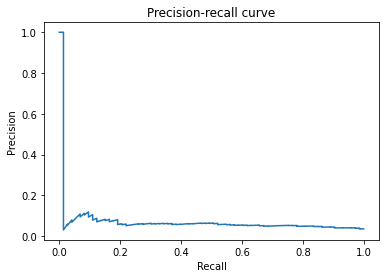

In [ ]:
precision, recall, threshold = precision_recall_curve(y_test, model_pred)
plt.figure()
plt.title("Precision-recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall, precision)


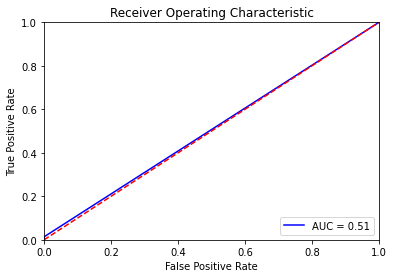

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()